# Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

* Demographics (city, age, gender etc.)
* Tenure information (joining date, Last Date)
* Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

# Column Profiling:

* MMMM-YY : Reporting Date (Monthly)
* Driver_ID : Unique id for drivers
* Age : Age of the driver
* Gender : Gender of the driver – Male : 0, Female: 1
* City : City Code of the driver
* Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
* Income : Monthly average Income of the driver
* Date Of Joining : Joining date for the driver
* LastWorkingDate : Last date of working for the driver
* Joining Designation : Designation of the driver at the time of joining
* Grade : Grade of the driver at the time of reporting
* Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
* Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

# Concepts Tested:

* Ensemble Learning- Bagging
* Ensemble Learning- Boosting
* KNN Imputation of Missing Values
* Working with an imbalanced dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
df.shape

(19104, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [5]:
df.isna().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

* There are 19104 rows and 14 columns
* Null Values observed in 3 columns
* Data type of few columns need correction, converting to date time etc..
* Data requires pre-processing before model building.

# Exploratory Data Analysis

* Feature Engineering
* Conversion to Required Data types
* Checking Null Values
* Checking Duplicates
* Checking Outliers

In [6]:
df1 = df.copy()

In [7]:
#Remove Unnamed column since we have Driver Id with unique values
df1.drop('Unnamed: 0', axis=1, inplace=True)

### Converting Required Columns to Datetime

In [8]:
df1 = df1.rename(columns={'MMM-YY': 'Reporting_Date'})

Reporting Date is in MM-DD-YY format and other 2 columns in DD-MM-YY format. Therefore, it needs attention while converting to datetime format

In [9]:
# Convert Reporting_Date to datetime, it's in MM-DD-YY format
df1['Reporting_Date'] = pd.to_datetime(df1['Reporting_Date'], format='%m/%d/%y',errors='coerce')

# Convert Dateofjoining to datetime, it's in DD-MM-YY format
df1['Dateofjoining'] = pd.to_datetime(df1['Dateofjoining'], format='%d/%m/%y',errors='coerce')

# Convert LastWorkingDate to datetime, it's in DD-MM-YY format
df1['LastWorkingDate'] = pd.to_datetime(df1['LastWorkingDate'], format='%d/%m/%y',errors='coerce')

In [10]:
# Non-numeric columns
obj_cols = df1.select_dtypes(include='object').columns
obj_cols

Index(['City'], dtype='object')

In [11]:
for _ in obj_cols:
    print()
    print(f'Total unique values in {_} columns are:- {df1[_].nunique()}')
    print(f'Value counts in {_} columns are:-\n{df1[_].value_counts()}')
    print()


Total unique values in City columns are:- 29
Value counts in City columns are:-
C20    1008
C29     900
C26     869
C22     809
C27     786
C15     761
C10     744
C12     727
C8      712
C16     709
C28     683
C1      677
C6      660
C5      656
C14     648
C3      637
C24     614
C7      609
C21     603
C25     584
C19     579
C4      578
C13     569
C18     544
C23     538
C9      520
C2      472
C11     468
C17     440
Name: City, dtype: int64



In [12]:
#Numeric columns
num_cols = df1.select_dtypes(include="number").columns
num_cols

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [13]:
for _ in num_cols:
    print()
    print(f'Total unique values in {_} columns are:- {df1[_].nunique()}')
    print(f'Value counts in {_} columns are:-\n{df1[_].value_counts(normalize=True)}')
    print()
    print("-"*120)


Total unique values in Driver_ID columns are:- 2381
Value counts in Driver_ID columns are:-
2110    0.001256
2617    0.001256
1623    0.001256
1642    0.001256
1644    0.001256
          ...   
1614    0.000052
445     0.000052
2397    0.000052
1619    0.000052
469     0.000052
Name: Driver_ID, Length: 2381, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total unique values in Age columns are:- 36
Value counts in Age columns are:-
36.0    0.067374
33.0    0.065641
34.0    0.064801
30.0    0.060180
32.0    0.060022
35.0    0.059759
31.0    0.056504
29.0    0.053195
37.0    0.045266
38.0    0.044846
39.0    0.041380
28.0    0.040540
27.0    0.039069
40.0    0.036811
41.0    0.034711
26.0    0.029722
42.0    0.025101
25.0    0.023578
44.0    0.021373
43.0    0.020953
45.0    0.019482
46.0    0.018379
24.0    0.014388
47.0    0.011763
23.0    0.010135
48.0    0.007562
49.0    0.005199
22.0    0.0048

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Reporting_Date        19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

### Feature Engineering

Target Variable Creation: Having value 1 if the Last Working Date of the Driver is present else 0

In [15]:
target = (df1.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
target['LastWorkingDate'].replace({True:0,False:1},inplace=True)
target.rename(columns={'LastWorkingDate':'Target'},inplace=True)
target.head()

,Driver_ID,Target
0,1,1
1,2,0
2,4,1
3,5,1
4,6,0


Rating_incr: If Quarterly Rating has increased than value 1 else 0

In [16]:
QR1 = (df1.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (df1.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [17]:
QR1.shape,QR2.shape

((2381, 2), (2381, 2))

In [18]:
QR1.isna().sum(), QR2.isna().sum()

(Driver_ID           0
 Quarterly Rating    0
 dtype: int64,
 Driver_ID           0
 Quarterly Rating    0
 dtype: int64)

In [19]:
target = target.merge(QR1,on='Driver_ID')
target = target.merge(QR2,on='Driver_ID')

In [20]:
target['Rating_incr']=np.where(target['Quarterly Rating_x'] < target['Quarterly Rating_y'], 1,0)

In [21]:
target.head()

,Driver_ID,Target,Quarterly Rating_x,Quarterly Rating_y,Rating_incr
0,1,1,2,2,0
1,2,0,1,1,0
2,4,1,1,1,0
3,5,1,1,1,0
4,6,0,1,2,1


Income_incr: If the monthly income has increased for any driver then value 1 else 0

In [22]:
incm1 = (df1.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (df1.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [23]:
incm1.shape, incm2.shape

((2381, 2), (2381, 2))

In [24]:
incm1.isna().sum(), incm2.isna().sum()

(Driver_ID    0
 Income       0
 dtype: int64,
 Driver_ID    0
 Income       0
 dtype: int64)

In [25]:
target = target.merge(incm1,on='Driver_ID')
target = target.merge(incm2,on='Driver_ID')

In [26]:
target['Income_incr'] = np.where(target['Income_x'] < target['Income_y'], 1,0)

New Features Created

In [27]:
target2= target[['Driver_ID','Target','Rating_incr','Income_incr']]
target2.head()

,Driver_ID,Target,Rating_incr,Income_incr
0,1,1,0,0
1,2,0,0,0
2,4,1,0,0
3,5,1,0,0
4,6,0,1,0


Aggregation and Merger of Columns based on Driver_ID

In [28]:
df2 = df1.copy()

In [29]:
functions = {'Reporting_Date':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
            'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
            'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
            'Income':'last',
             'Joining Designation':'last',
             'Quarterly Rating':'last'}
df2 = df2.groupby([df2['Driver_ID']]).aggregate(functions)
df2.rename(columns={'Reporting_Date':'Reportings'},inplace=True)

In [30]:
df2.reset_index(drop=True, inplace=True)
df2 = df2.merge(target2,on='Driver_ID')

In [31]:
df2.columns = df2.columns.str.strip()
df2

,Reportings,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,Rating_incr,Income_incr
0,3,1,28.0,0.0,C23,2,2018-12-24,2019-11-03,1,1715580,57387,1,2,1,0,0
1,2,2,31.0,0.0,C7,2,2020-06-11,NaT,2,0,67016,2,1,0,0,0
2,5,4,43.0,0.0,C13,2,2019-07-12,2020-04-27,2,350000,65603,2,1,1,0,0
3,3,5,29.0,0.0,C9,0,2019-09-01,2019-07-03,1,120360,46368,1,1,1,0,0
4,5,6,31.0,1.0,C11,1,2020-07-31,NaT,3,1265000,78728,3,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,24,2784,34.0,0.0,C24,0,2015-10-15,NaT,3,21748820,82815,2,4,0,1,0
2377,3,2785,34.0,1.0,C9,0,2020-08-28,2020-10-28,1,0,12105,1,1,1,0,0
2378,9,2786,45.0,0.0,C19,0,2018-07-31,2019-09-22,2,2815090,35370,2,1,1,0,0
2379,6,2787,28.0,1.0,C20,2,2018-07-21,2019-06-20,1,977830,69498,1,1,1,0,0


* Finally we got our aggregated dataset with Target variable
* There are 2381 rows and 16 columns signifying unique 2381 Driver ids

### Checking Null Values

In [32]:
df2.isna().sum()

Reportings                0
Driver_ID                 0
Age                       0
Gender                    0
City                      0
Education_Level           0
Dateofjoining             0
LastWorkingDate         765
Grade                     0
Total Business Value      0
Income                    0
Joining Designation       0
Quarterly Rating          0
Target                    0
Rating_incr               0
Income_incr               0
dtype: int64

For the null values only in LastWorkingDate column is present for the reason that Driver have not left. We shall be using this feature so keeping it as it is

### Checking for Duplicates



In [33]:
df2[df2.duplicated()]

,Reportings,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,Rating_incr,Income_incr


No duplicate data observed

### Checking Outliers



In [34]:
num_cols=['Reportings','Age','Total Business Value','Income']

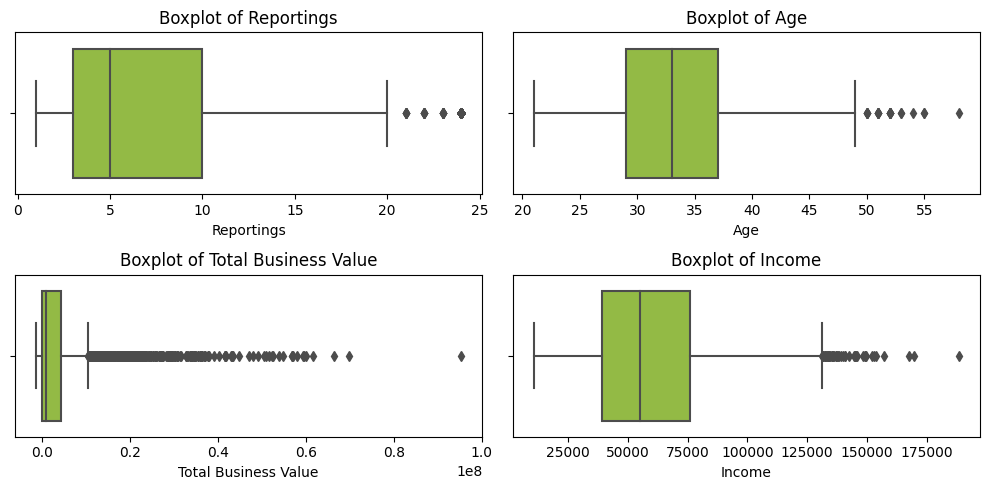

In [35]:
fig = plt.figure(figsize=(10,5))
i=1
for col in num_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(x=df2[col],color='yellowgreen')
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

**Highlights:**

* Data is showing outliers esp. in Total Business Value
* We have limited dataset and varied values are signifying the range for each Driver, we must keep intact the diversity so that we can make better predictions for any new data which can be of any range.

# Analysis and Distribution of Variables

* Statistical Summary
* UniVariate Analysis
* Bivariate Analysis
* Impact of Each Feature on Churn

**Statistical Summary**



In [36]:
df3 = df2.copy()

In [37]:
df3.nunique()

Reportings                24
Driver_ID               2381
Age                       36
Gender                     2
City                      29
Education_Level            3
Dateofjoining            869
LastWorkingDate          493
Grade                      5
Total Business Value    1629
Income                  2339
Joining Designation        5
Quarterly Rating           4
Target                     2
Rating_incr                2
Income_incr                2
dtype: int64

In [38]:
columns_to_convert=['Reportings', 'Gender', 'City', 'Education_Level', 'Grade', 'Joining Designation', 'Quarterly Rating', 'Rating_incr', 'Income_incr', 'Target']

In [39]:
df3[columns_to_convert] = df3[columns_to_convert].apply(lambda x: x.astype('category'))

In [40]:
df3.describe(include='all').T

C:\Users\ABBAS\AppData\Local\Temp\ipykernel_5372\330226572.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df3.describe(include='all').T
C:\Users\ABBAS\AppData\Local\Temp\ipykernel_5372\330226572.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df3.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Reportings,2381.0,24.0,5.0,309.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driver_ID,2381.0,NaN,NaN,NaN,NaT,NaT,1397.559009,806.161628,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,NaN,NaN,NaN,NaT,NaT,33.663167,5.983375,21.0,29.0,33.0,37.0,58.0
Gender,2381.0,2.0,0.0,1404.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,2381,29,C20,152,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Level,2381.0,3.0,2.0,802.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dateofjoining,2381,869,2020-07-31 00:00:00,31,2013-01-04,2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LastWorkingDate,1616,493,2020-07-29 00:00:00,70,2018-12-31,2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grade,2381.0,5.0,2.0,855.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Business Value,2381.0,NaN,NaN,NaN,NaT,NaT,4586741.822764,9127115.313446,-1385530.0,0.0,817680.0,4173650.0,95331060.0


Observations:

* Five number of reportings are having highest frequency
* Males are higher in ratio than females among Drivers
* C20 is the city with maximum drivers
* Maximum Drivers have Grade 2
* Maximum number of Drivers have Quarterly Rating as 1

In [41]:
num_cols=['Reportings', 'Age', 'Total Business Value', 'Income']

In [42]:
#Considering a few integer datatype columns as categorical since they have got limited unique values and categorical in nature for EDA purpose
cat_cols=['Gender','City','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr','Target']

**Categorical Features**

In [43]:
for _ in cat_cols:
    print()
    print(f"Total unique values in {_} column are:- {df2[_].nunique()}")
    print(f"Value counts in {_} column are:-\n {df2[_].value_counts(normalize=True)}")
    print()
    print("-"*120)


Total unique values in Gender column are:- 2
Value counts in Gender column are:-
 0.0    0.589668
1.0    0.410332
Name: Gender, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total unique values in City column are:- 29
Value counts in City column are:-
 C20    0.063839
C15    0.042419
C29    0.040319
C26    0.039059
C8     0.037379
C27    0.037379
C10    0.036119
C16    0.035279
C22    0.034439
C3     0.034439
C28    0.034439
C12    0.034019
C5     0.033599
C1     0.033599
C21    0.033179
C14    0.033179
C6     0.032759
C4     0.032339
C7     0.031919
C9     0.031499
C25    0.031079
C23    0.031079
C24    0.030659
C19    0.030239
C2     0.030239
C17    0.029819
C13    0.029819
C18    0.028979
C11    0.026879
Name: City, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total unique values in Education_Level c

In [44]:
newcat_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr','Target']

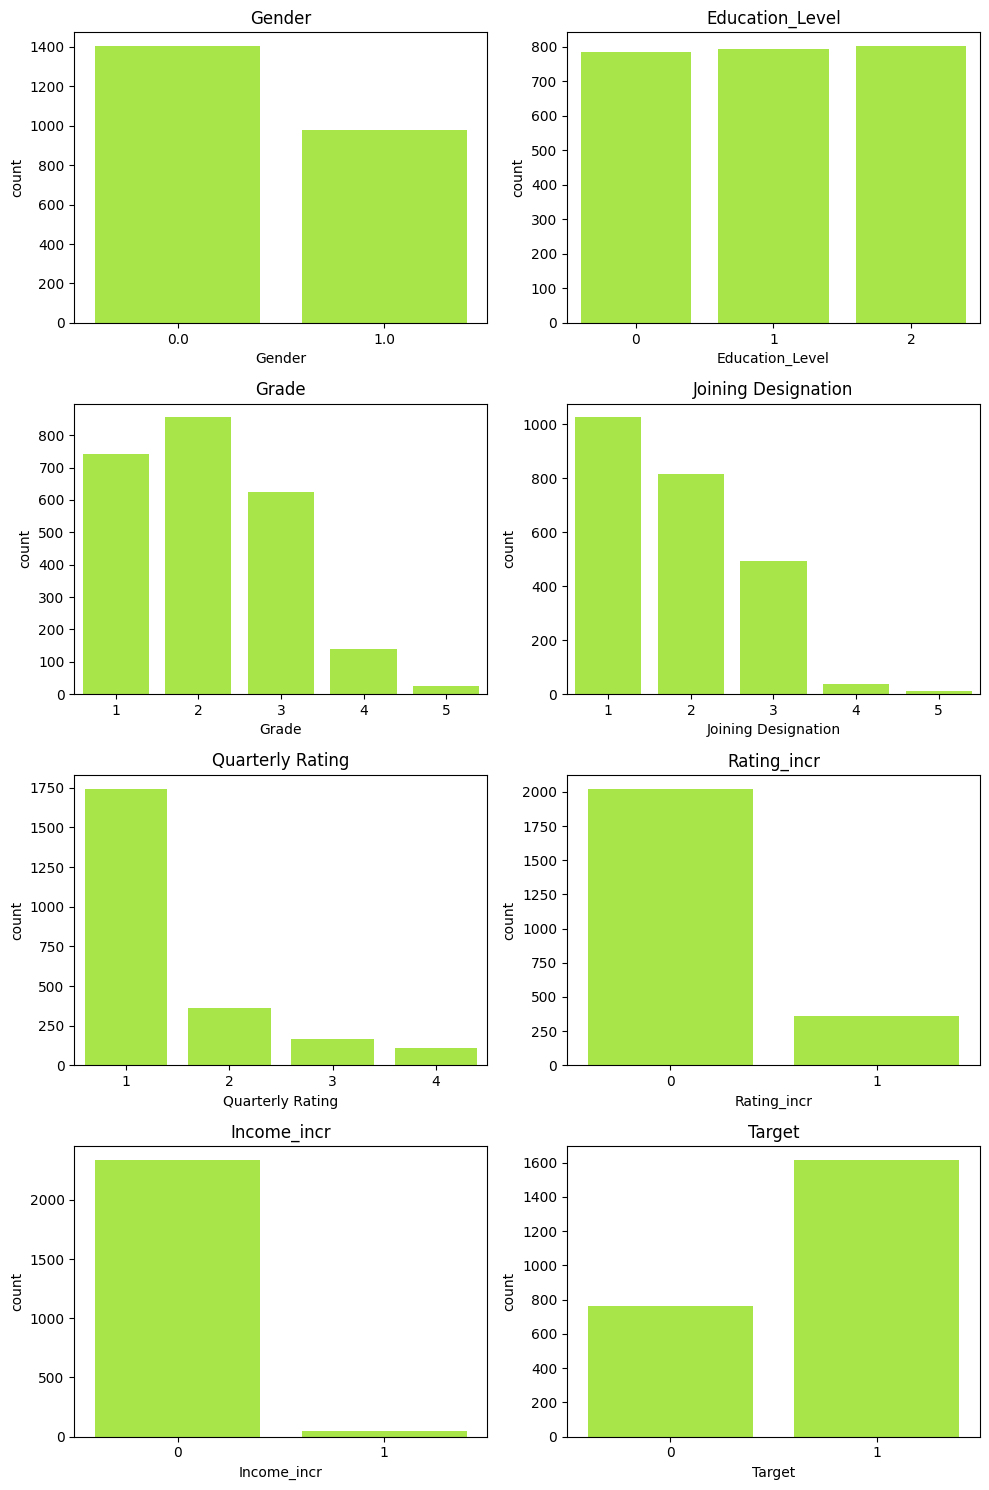

In [45]:
plt.figure(figsize=(10,15))
i=1
for col in newcat_cols:
    ax=plt.subplot(4,2,i)
    sns.countplot(x=df2[col],color='greenyellow')
    plt.title(f'{col}')
    i += 1

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of City')

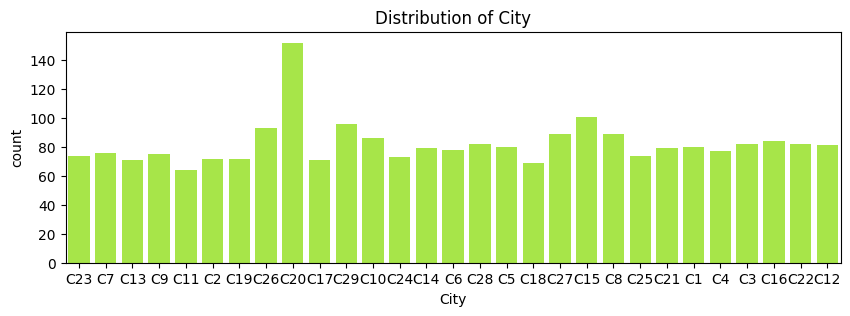

In [46]:
plt.figure(figsize=(10,3))
sns.countplot(x=df2['City'],color='greenyellow')
plt.title('Distribution of City')

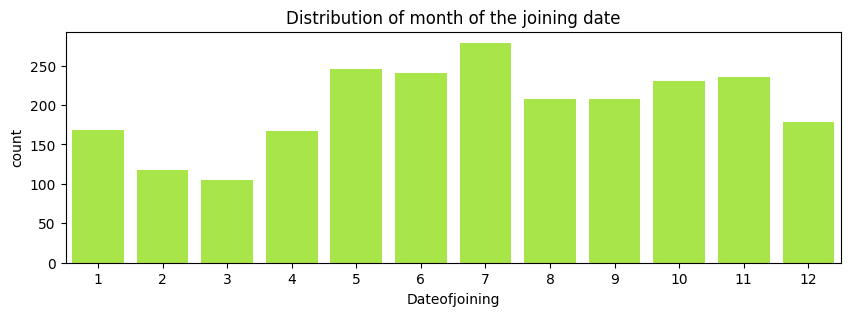

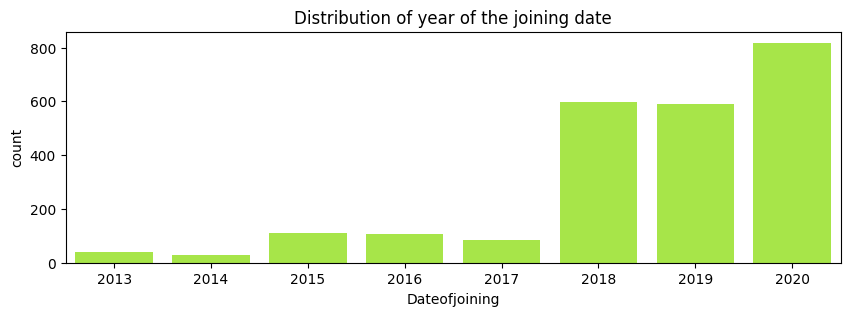

In [47]:
plt.figure(figsize=(10, 3))
sns.countplot(x=df2['Dateofjoining'].dt.month, color='greenyellow')
plt.title('Distribution of month of the joining date')

plt.figure(figsize=(10, 3))
sns.countplot(x=df2['Dateofjoining'].dt.year, color='greenyellow')
plt.title('Distribution of year of the joining date')

plt.show()

**Total Business Value w.r.t Grade**

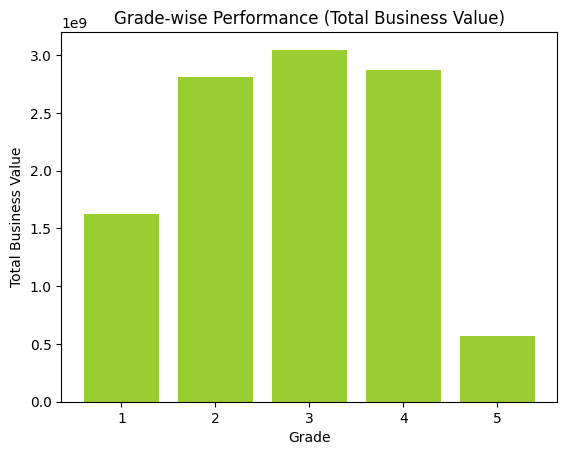

In [48]:
# Group data by grade and calculate total business value
grade_wise_value = df2.groupby('Grade')['Total Business Value'].sum()

#create the plot
plt.bar(grade_wise_value.index, grade_wise_value.values, color='yellowgreen')
plt.xlabel('Grade')
plt.ylabel('Total Business Value')
plt.title('Grade-wise Performance (Total Business Value)')
plt.show()

**City with Most Improvement in Quarterly Rating over the past year**

In [49]:
df4 = df1.copy()

It is determined w.r.t year of the last Reporting Date in the dataset

In [50]:
df4['Reporting_Date'] = pd.to_datetime(df4['Reporting_Date'])

# Use the last date from the dataset as the reference date
last_date = df4['Reporting_Date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)

# Filter data for the past year
df_past_year = df4[df4['Reporting_Date'] >= one_year_ago]

# Check if the DataFrame after filtering is empty
if df_past_year.empty:
    raise ValueError("No data available for the past year. Please check the date range or the data.")

# Group by city and calculate the change in Quarterly Rating
rating_change = df_past_year.groupby('City').agg(
    start_rating=('Quarterly Rating', 'first'),
    end_rating=('Quarterly Rating', 'last')
).reset_index()

# Calculate the improvement (change) in Quarterly Rating
rating_change['rating_improvement'] = rating_change['end_rating'] - rating_change['start_rating']

In [51]:
if rating_change.empty or rating_change['rating_improvement'].isnull().all():
    raise ValueError("No improvements found. Please check the data.")
    
# Find the city with the greatest improvement
most_improved_city = rating_change.loc[rating_change['rating_improvement'].idxmax(), 'City']
print(f"The city with the most improvement in Quarterly Rating over the past year is: {most_improved_city}")

The city with the most improvement in Quarterly Rating over the past year is: C22


**Total Business Value w.r.t City**

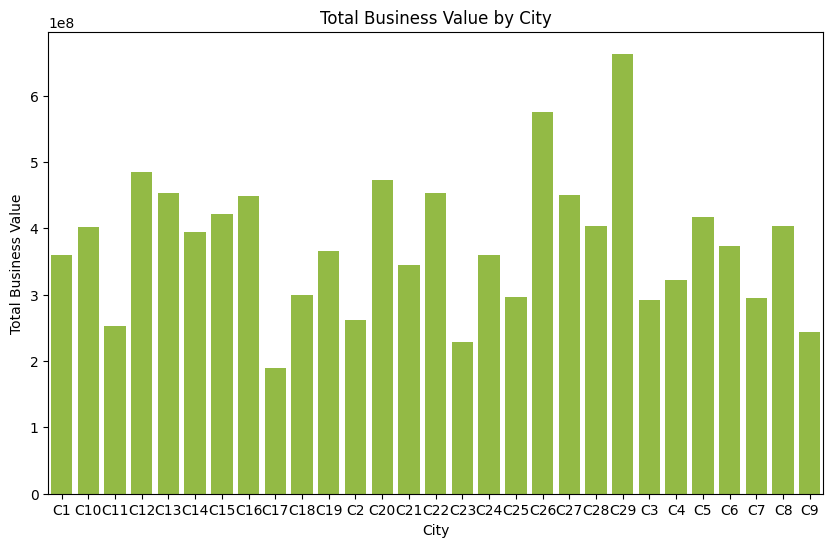

In [52]:
## Aggregate total business value by city
city_tbv = df4.groupby('City')['Total Business Value'].sum().reset_index()

# Plot the total business value for each city
plt.figure(figsize=(10, 6))
sns.barplot(data=city_tbv, x='City', y='Total Business Value', color='yellowgreen')
plt.title('Total Business Value by City')
plt.xlabel('City')
plt.ylabel('Total Business Value')
plt.show()

**Impact of Time of the Year on Quarterly Rating**

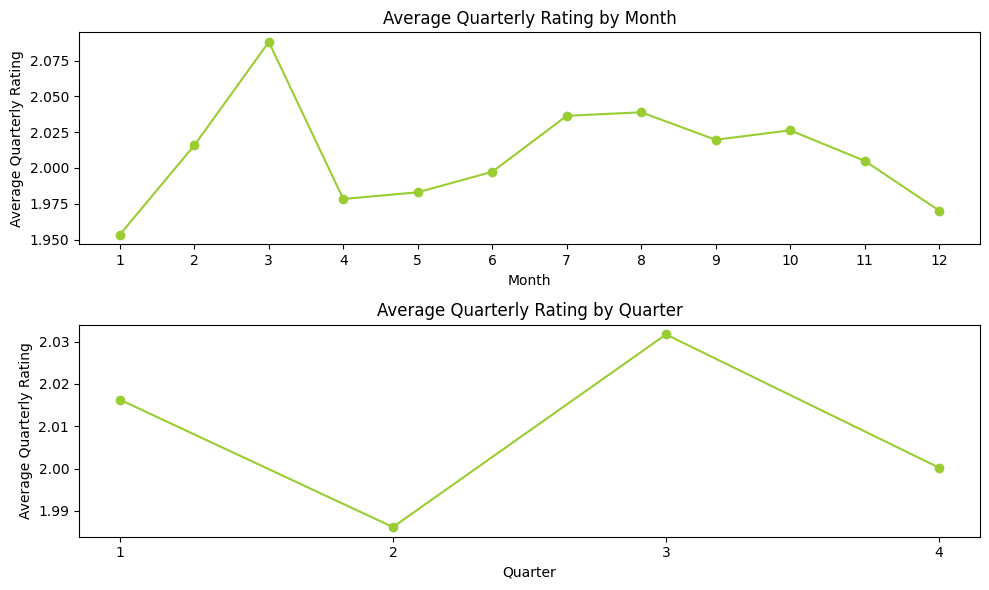

In [53]:
df4['Month'] = df4['Reporting_Date'].dt.month
df4['Quarter'] = df4['Reporting_Date'].dt.quarter

# Aggregate Quarterly Ratings by month and quarter
ratings_by_month = df4.groupby('Month')['Quarterly Rating'].mean()
ratings_by_quarter = df4.groupby('Quarter')['Quarterly Rating'].mean()

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(ratings_by_month, marker='o',color='yellowgreen')
plt.title('Average Quarterly Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Quarterly Rating')
plt.xticks(range(1, 13))

plt.subplot(2, 1, 2)
plt.plot(ratings_by_quarter, marker='o',color='yellowgreen')
plt.title('Average Quarterly Rating by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Quarterly Rating')
plt.xticks(range(1, 5))

plt.tight_layout()
plt.show()

Observations:

* 68% of the Drivers have been churned
* Hardly 2% of the Drivers got Increment in Income
* 15% of the Drivers got Increase in Rating
* 73% had their last Quarter Rating as 1 followed by 15% having 2
* Joining Designation is highest for 1 with 43% followed by 2 with 34%
* Grade at the time of Reporting is highest for Grade 2 with 36% followed by Grade 1 with 31%
* Distribution of Education Level for all 3 levels is almost same with 33%
* C20 is the city with highest number of drivers followed C15
* Males are higher in numbers with 59% and Females at 41%
* Most of the Drivers had their last working date in the month of July and year 2019
* Most of the Drivers joined in the month of July and year 2020
* Drivers with Grade 3 have highest business value followed by Grade 4 and 2
* The city with the most improvement in Quarterly Rating over the past year is C22
* Total Business Value of Drivers is highest in C29 followed by C26
* Average Quarterly Rating is found to be highest in 3rd Quarter and the same is found highest in the month of March

**Impact of Each Feature on Churn**

In [54]:
newcat1_cols=['Gender','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr']

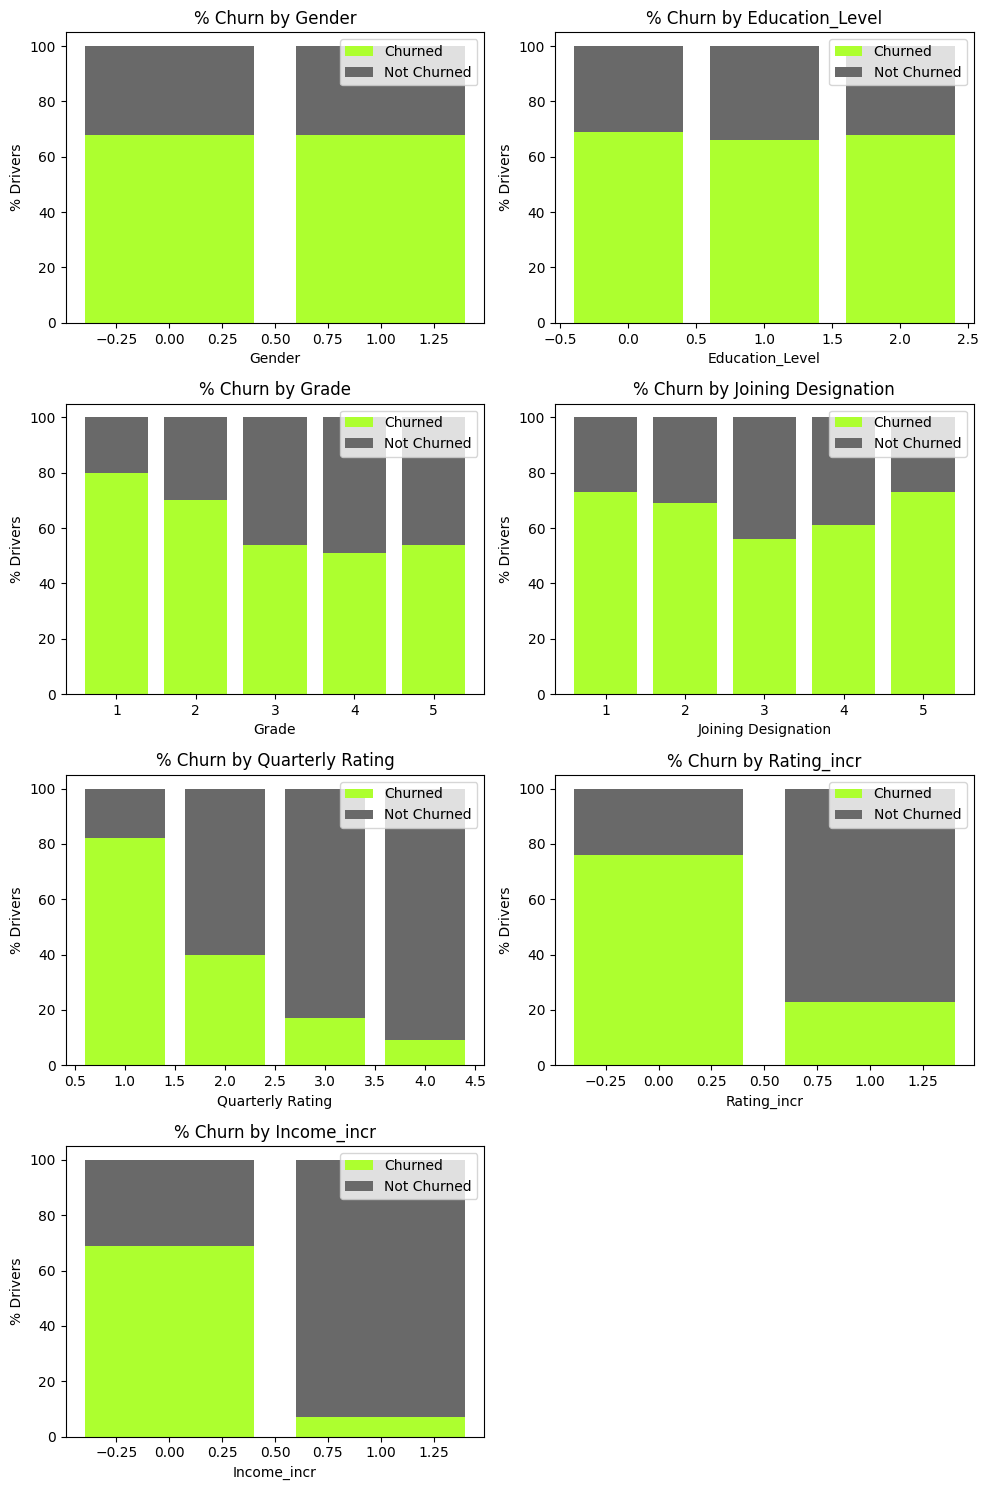

In [55]:
plt.figure(figsize=(10,15))
i=1
for col in newcat1_cols:
    ax = plt.subplot(4, 2, i)
    
    data = df2.pivot_table(index=col, columns='Target', aggfunc='size')
    
    # Convert counts to percentages
    data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
    data.reset_index(inplace=True)
    
    # Plotting the bars
    plt.bar(data[col], data[1], color='greenyellow', label='Churned')
    plt.bar(data[col], data[0], color='dimgrey', bottom=data[1], label='Not Churned')
    
    plt.xlabel(f'{col}')
    plt.ylabel('% Drivers')
    plt.title(f'% Churn by {col}')
    plt.legend(['Churned', 'Not Churned'])

    i += 1
    
plt.tight_layout()
plt.show()


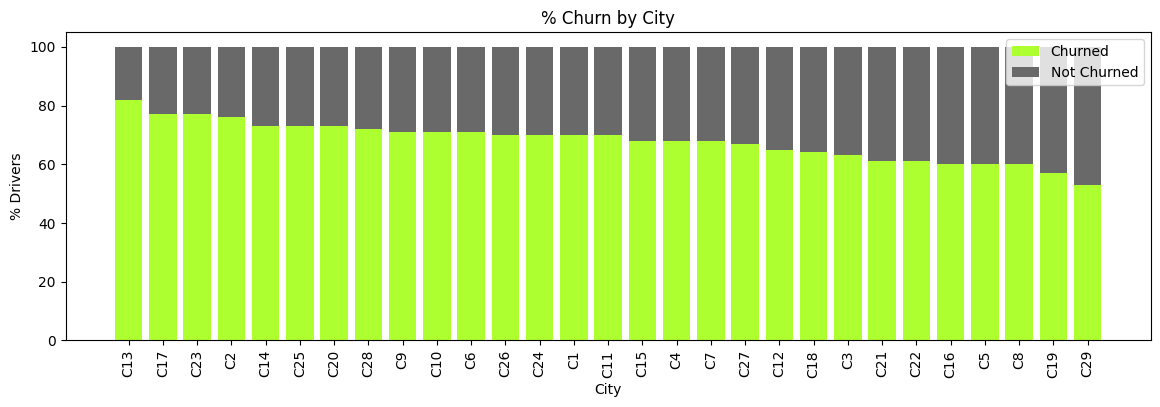

In [56]:
city = df2.pivot_table(index='City', columns='Target', aggfunc="size")
city = city.div(city.sum(axis=1), axis=0).multiply(100).round()
city.reset_index(inplace=True)
city = city.sort_values(by=1, ascending=False)

plt.figure(figsize=(14, 4))
plt.bar(city['City'], city[1], color="greenyellow")
plt.bar(city['City'], city[0], color="dimgrey", bottom=city[1])

# Labeling and titles
plt.title('% Churn by City')
plt.xlabel("City")
plt.ylabel('% Drivers')
plt.legend(['Churned', 'Not Churned'])
plt.xticks(rotation=90)
plt.show()

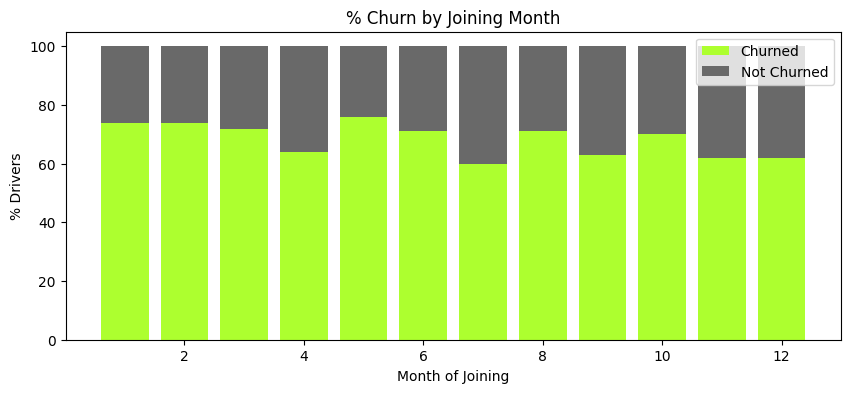

In [57]:
m = df2.pivot_table(index=df2['Dateofjoining'].dt.month, columns='Target', aggfunc='size')
m = m.div(m.sum(axis=1), axis=0).multiply(100).round()
m.reset_index(inplace=True)

plt.figure(figsize=(10,4))
plt.bar(m['Dateofjoining'], m[1], color='greenyellow')
plt.bar(m['Dateofjoining'], m[0], color='dimgrey', bottom=m[1])

# Labeling and titles
plt.xlabel('Month of Joining')
plt.ylabel('% Drivers')
plt.title(f'% Churn by Joining Month')
plt.legend(['Churned', 'Not Churned'])
plt.show()
     

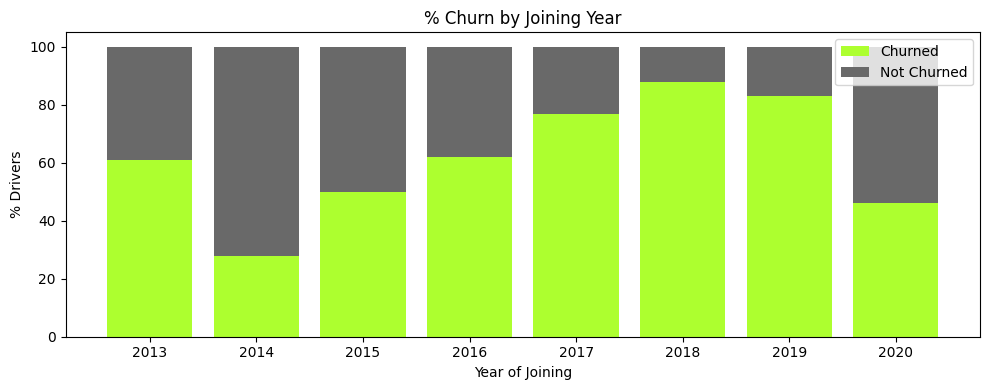

In [58]:
y = df2.pivot_table(index=df2['Dateofjoining'].dt.year, columns='Target', aggfunc='size')
y = y.div(y.sum(axis=1), axis=0).multiply(100).round()
y.reset_index(inplace=True)

plt.figure(figsize=(10,4))
plt.bar(y['Dateofjoining'], y[1], color='greenyellow')
plt.bar(y['Dateofjoining'], y[0], color='dimgrey', bottom=y[1])

plt.xlabel('Year of Joining')
plt.ylabel('% Drivers')
plt.title(f'% Churn by Joining Year')
plt.legend(['Churned', 'Not Churned'])
plt.tight_layout()
plt.show()

Observations:

* There is no effect of Gender and Education Level on Churn
* 80% of the Drivers with Grade 1 got churned followed by Grade 2 with almost 70% churn
* Drivers with Joining Designation 1 and 5 got churned the most with almost 75%
* 80% of the Drivers with Quarterly Rating 1 left the company followed by 40% of QR2 and almost 18% of QR3
* Almost 77% of the Drivers who did not get any increase in Rating left the company
* 70% of the Drivers who did not get any increment in income left the company
* 80% of the Drivers from City C13 left the company closely followed by C17 and C23
* There is no significant observation on churn w.r.t joining month
* 90% of the Drivers who joined in the year 2018 left the company followed by 2019 and 2017

**Numerical Features**

In [59]:
for _ in num_cols:
    print()
    print(f'Total Unique Values in {_} column are :- {df2[_].nunique()}')
    print(f'Value counts in {_} column are :-\n {df2[_].value_counts(normalize=True)}')
    print()
    print('-'*120)


Total Unique Values in Reportings column are :- 24
Value counts in Reportings column are :-
 5     0.129777
3     0.110458
4     0.102898
24    0.096178
2     0.085258
6     0.082738
1     0.076018
7     0.057119
9     0.045779
8     0.043259
10    0.023520
11    0.023100
13    0.021000
14    0.020580
12    0.018060
18    0.013020
15    0.010500
17    0.010080
19    0.008400
16    0.007560
20    0.006300
23    0.003360
22    0.002520
21    0.002520
Name: Reportings, dtype: float64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in Age column are :- 36
Value counts in Age column are :-
 32.0    0.072239
31.0    0.071819
34.0    0.069299
30.0    0.064259
33.0    0.060479
35.0    0.057539
36.0    0.057539
29.0    0.054599
37.0    0.051239
28.0    0.050399
27.0    0.046619
38.0    0.039479
39.0    0.035699
25.0    0.032759
26.0    0.031919
41.0    0.031499
40.0    0.026459
42.0    0.022260
24.0 

In [60]:
import warnings
import matplotlib.colors as mcolors

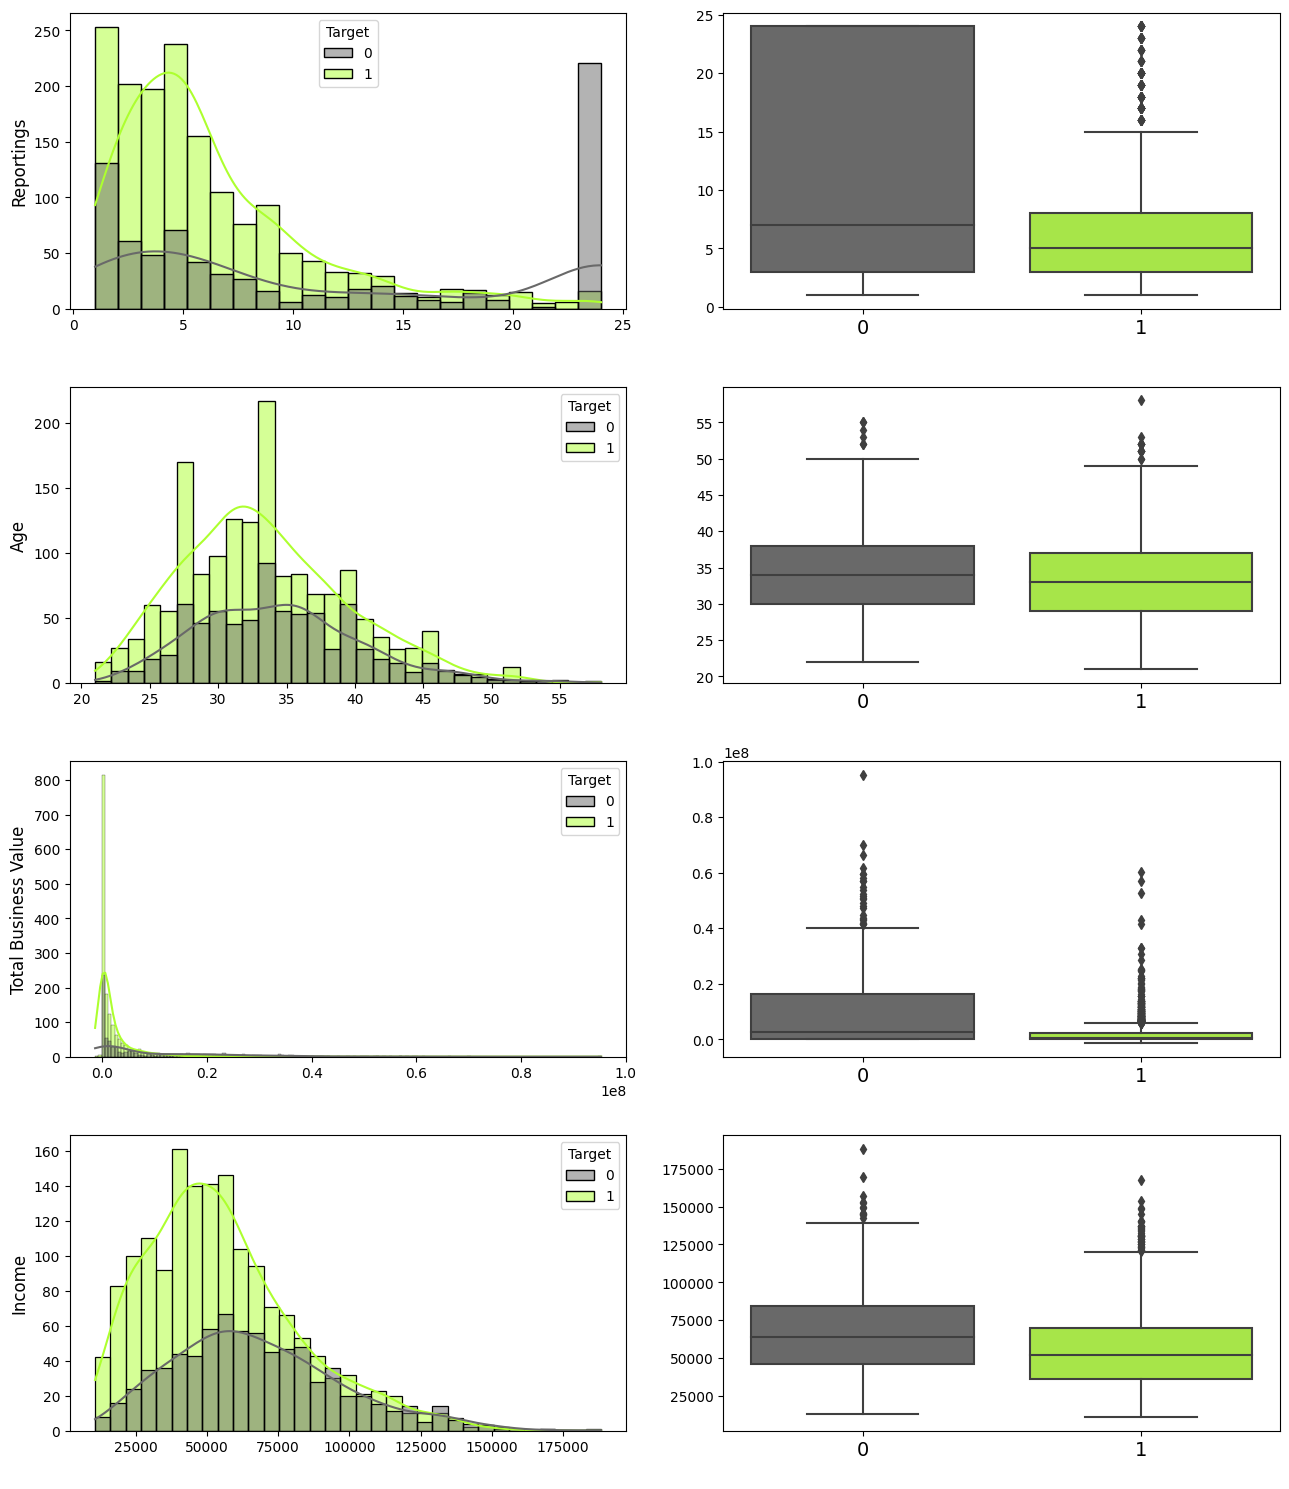

In [61]:
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(4,2,figsize=(13,15))
i=0
color_dict = {0: 'dimgrey', 1: 'greenyellow'}
for col in num_cols:
    sns.boxplot(data=df2, y=col, x='Target', ax=ax[i,1],
               palette=('dimgrey','greenyellow'))
    sns.histplot(data=df2, x=col, hue='Target', ax=ax[i, 0], legend=True,
                palette=color_dict, kde=True, fill=True)
    ax[i,0].set_ylabel(col, fontsize=12)
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    i += 1

plt.tight_layout()
plt.show()

Observations:

* Number of Reportings and Age are relatively lesser for Drivers who left
* Most of the Drivers getting churned belong to age between 25-35. Distribution is close to normal
* Income is less for the Drivers who left. Distribution is slightly right skewed
* Total Business Value is lesser for Drivers who left. Distribution is right skewed

# Relationship Among Features

* Correlation
* OLS Regression Analysis
* Hypothesis Testing

In [62]:
numerical_df2 = df2.select_dtypes(include=['int64', 'float64'])

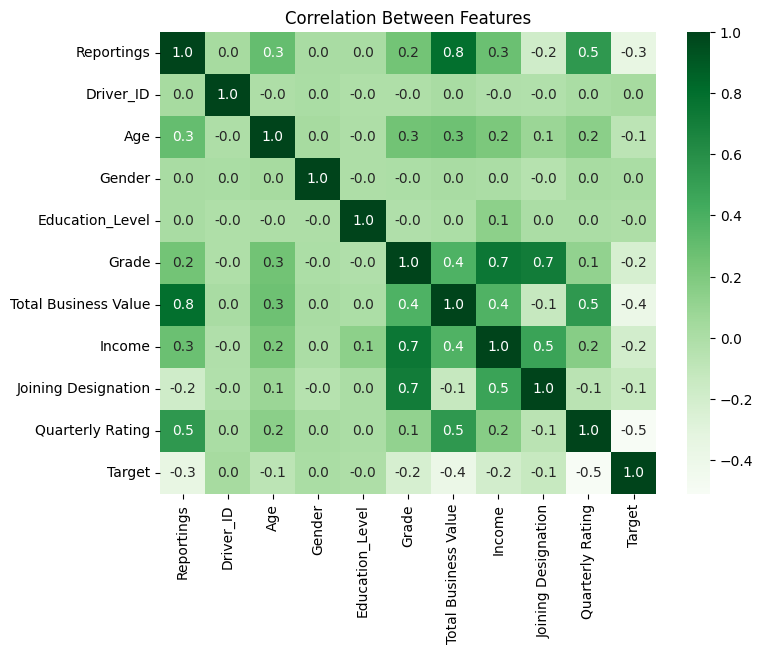

In [63]:
#Correlation among features
plt.figure(figsize=(8,6))
sns.heatmap(numerical_df2.corr(), annot=True, fmt='.1f', cmap='Greens')
plt.title('Correlation Between Features')
plt.show()

Highlights:

* Reportings is highly positively correlated to Total Business Value
* Quarterly Rating and Rating_incr are highly correlated for obvious reasons
* Grade is highly positively correlated to Income and Joining Designations
* We can consider to drop few of these features basis above observations. However, multicollinearity can arise due to the combined influence of multiple features, not just pairs.

Setting a single threshold for correlation coefficients to identify features for removal can be arbitrary and might not reflect the true impact on the model.Finally we can conclude this with Feature Importance

**Impact of Significant drop in Quarterly Rating over Total Business Value in subsequent period**

In [64]:
import statsmodels.api as sm

In [65]:
# Define a significant drop in Quarterly Rating
significant_drop_threshold = 2  # Example: A drop of 2 or more points

# Calculate the difference in Quarterly Rating between consecutive quarters
df4['Rating_Drop'] = df4.groupby('Driver_ID')['Quarterly Rating'].diff()

# Identify periods with significant drops
df4['Significant_Drop'] = df4['Rating_Drop'] <= -significant_drop_threshold

# Shift Total Business Value to get the subsequent period's value
df4['Subsequent_Business_Value'] = df4.groupby('Driver_ID')['Total Business Value'].shift(-1)

# Filter rows with significant drops
significant_drops = df4[df4['Significant_Drop']]

# Prepare data for regression analysis
regression_data = significant_drops[['Rating_Drop', 'Subsequent_Business_Value']].dropna()

# Add a constant to the independent variable (required for statsmodels)
regression_data = sm.add_constant(regression_data)

# Fit the regression model
model = sm.OLS(regression_data['Subsequent_Business_Value'], regression_data[['const', 'Rating_Drop']])
results = model.fit()

# Display the regression results
print(results.summary())

# Interpretation of results
if results.pvalues['Rating_Drop'] < 0.05:
    print("There is a significant impact of rating drops on the subsequent period's business value.")
else:
    print("There is no significant impact of rating drops on the subsequent period's business value.")

                                OLS Regression Results                               
Dep. Variable:     Subsequent_Business_Value   R-squared:                       0.034
Model:                                   OLS   Adj. R-squared:                  0.031
Method:                        Least Squares   F-statistic:                     10.04
Date:                       Sun, 26 Jan 2025   Prob (F-statistic):            0.00170
Time:                               12:30:43   Log-Likelihood:                -4078.8
No. Observations:                        284   AIC:                             8162.
Df Residuals:                            282   BIC:                             8169.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

Above analysis helps determine that there is statistically significant impact of drop in Quarterly Rating on the subsequent period's Business Value

**Which all Features have impact on Quarterly Rating**

In [66]:
df5=df4.copy()

In [67]:
numerical_df = df5.select_dtypes(include=['int64', 'float64'])

# Remove non-relevant columns
exclude_columns = ['Reporting_Date', 'Dateofjoining', 'LastWorkingDate']
numerical_df = numerical_df.drop(columns=exclude_columns, errors='ignore')

# Drop rows with missing values
numerical_df.dropna(inplace=True)

# Separate the target variable and features
X = numerical_df.drop('Quarterly Rating', axis=1)
y = numerical_df['Quarterly Rating']

# Add a constant to the feature matrix (required for statsmodels)
X = sm.add_constant(X)

# Fit the regression model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

# Extract p-values from the model summary
p_values = model.pvalues

# Filter features with p-value less than 0.05
significant_features = p_values[p_values < 0.05].index.tolist()

# Remove the constant term if it's included in the significant features
if 'const' in significant_features:
    significant_features.remove('const')

print("Significant numerical features impacting Quarterly Rating:")
for feature in significant_features:
    print(feature)

                            OLS Regression Results                            
Dep. Variable:       Quarterly Rating   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     897.5
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:30:43   Log-Likelihood:                -16490.
No. Observations:               14441   AIC:                         3.301e+04
Df Residuals:                   14428   BIC:                         3.310e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Above OLS summary indicate impact of Age,Gender,Income,Joining Designation, Grade, Total Business Value on Quarterly Rating

**Hypothesis Testing**

In [68]:
from scipy.stats import chi2_contingency

In [69]:
newcat2_cols=['Reportings','Gender','City','Education_Level','Grade','Joining Designation','Quarterly Rating','Rating_incr','Income_incr']

In [70]:
for col in newcat2_cols:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df3[col], df3['Target']))
    if p > 0.05:
        print('>>>>>>> Independent feature - Not Significant:',col,' >> p value:',p)

>>>>>>> Independent feature - Not Significant: Gender  >> p value: 0.6943902798506425
>>>>>>> Independent feature - Not Significant: Education_Level  >> p value: 0.46643939521309963


Based on Hypothesis Testing and as observed in our Graphical Impact analysis of Churn on Gender and Education_Level, we found same observation that these features are not significant for determining Churn.

# Data Preparation for Modeling

* Encoding
* Scaling
* Train Test Split
* Class Imbalance- SMOTE

In [71]:
df_prep=df2.drop(columns=['Driver_ID','LastWorkingDate'],axis=1)

In [72]:
df_prep['Month']=df_prep['Dateofjoining'].dt.month
df_prep['Year']=df_prep['Dateofjoining'].dt.year

In [73]:
df_prep.drop('Dateofjoining',axis=1,inplace=True)

**One Hot Encoding**

In [74]:
df_encoded = pd.get_dummies(df_prep,'City', drop_first=True)*1
df_encoded.head()

,Reportings,Age,Gender,Education_Level,Grade,Total Business Value,Income,Joining Designation,Quarterly Rating,Target,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,3,28.0,0.0,2,1,1715580,57387,1,2,1,...,0,0,0,0,0,0,0,0,0,0
1,2,31.0,0.0,2,2,0,67016,2,1,0,...,0,0,0,0,0,0,0,1,0,0
2,5,43.0,0.0,2,2,350000,65603,2,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,29.0,0.0,0,1,120360,46368,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,5,31.0,1.0,1,3,1265000,78728,3,2,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
df_encoded.shape

(2381, 42)

**Train Test Split**

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
#Prepare X and y dataset i.e. independent and dependent datasets

X = df_encoded.drop(['Target'], axis=1)
y = df_encoded['Target']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling**

In [79]:
from sklearn.preprocessing import MinMaxScaler

In [80]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

**Check Class Imbalance**

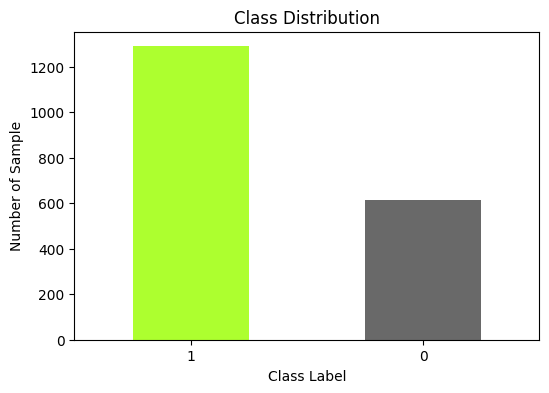

Class Ratio (Majority / Minority): 2.10


In [81]:
# Count class frequencies
class_counts = y_train.value_counts()

# create a bar chart
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['greenyellow', 'dimgrey'])
plt.xlabel('Class Label')
plt.ylabel('Number of Sample')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

# Print class ratio (optional)
print(f"Class Ratio (Majority / Minority): {class_counts.iloc[0] / class_counts.iloc[1]:.2f}")

**SMOTE**

(Synthetic Minority Over-sampling Technique) is often used to handle imbalanced datasets, especially when the target variable has significantly fewer instances of one class compared to the other. If our binary classification problem has an imbalanced target variable, applying SMOTE can help improve model performance by generating synthetic samples of the minority class.

In [82]:
from imblearn.over_sampling import SMOTE

In [83]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

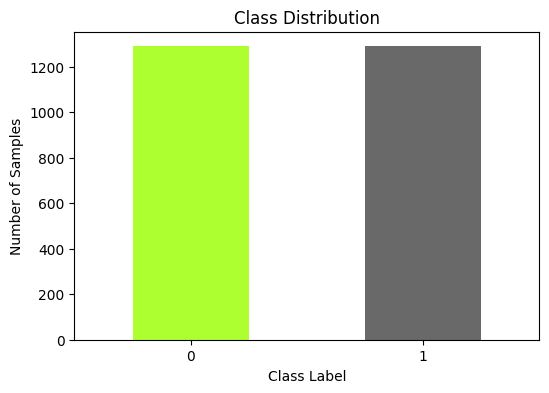

Class Ratio (Majority / Minority): 1.00


In [84]:
# Count class frequencies
class_counts = y_train_res.value_counts()

# Create a bar chart
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['greenyellow', 'dimgrey'])
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

# Print class ratio (optional)
print(f"Class Ratio (Majority / Minority): {class_counts.iloc[0] / class_counts.iloc[1]:.2f}")

# Ensemble Learning: Bagging (Random Forest Classifier)

* Hyperparameter Tuning using GridsearchCV
* Model Score / Accuracy Measurement
* Confusion Matrix
* Feature Importance
* ROC Curve & AUC
* Precision Recall Curve 

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

In [86]:
params = {
    "max_depth":[7,10,15],
    "n_estimators":[100,200,300,400],
    "max_features":[4,7,10],
    "ccp_alpha":[0.0005,0.00075,0.001]
}

In [87]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=5, n_jobs=-1, verbose=2)

# Measure the time taken to fit the model
start_time = time.time()
grid_search.fit(X_train_res, y_train_res)
end_time = time.time()

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print(f"Total training time: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by GridSearchCV: {'ccp_alpha': 0.0005, 'max_depth': 15, 'max_features': 7, 'n_estimators': 100}
Total training time: 181.25 seconds


In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [89]:
# Retrieve the best model (estimator)
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_train_pred = best_model.predict(X_train_res)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the model
# Accuracy
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.98
Test Accuracy: 0.89


In [90]:
grid_search.best_score_

0.9150666064574395

Observations:

* Training Accuracy: 0.98: This denotes that during the training phase, the Random Forest model achieved an accuracy of 98% on the training data. This high training accuracy suggests that the model was able to fit the training data quite well.


* Test Accuracy: 0.89: After training, when the model was evaluated on unseen or test data, it achieved an accuracy of 89%. This accuracy represents how well the model generalizes to new, unseen data. An accuracy of 89% suggests that the model performs well on the test data, although it's slightly lower than the training accuracy, which is expected.


* Model Best Score is 0.915: This score likely refers to the best cross-validated score achieved during the hyperparameter tuning process. The score of 0.915 suggests that the model achieved a high performance metric (such as accuracy, F1-score, etc.) during cross-validation with the best set of hyperparameters found by GridSearchCV.

**Confusion Matrix / Classification Report**

In [91]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix: ")
print(conf_matrix)

Confusion matrix: 
[[127  23]
 [ 28 299]]


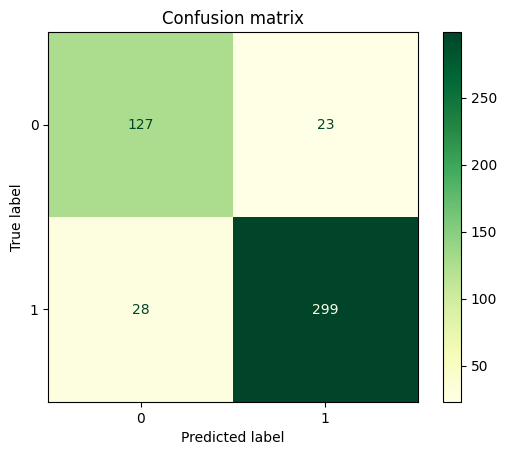

In [92]:
disp = ConfusionMatrixDisplay(conf_matrix)
cmap = plt.cm.YlGn
disp.plot(cmap=cmap)
plt.title("Confusion matrix")
plt.show()

In [93]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       150
           1       0.93      0.91      0.92       327

    accuracy                           0.89       477
   macro avg       0.87      0.88      0.88       477
weighted avg       0.89      0.89      0.89       477



Observations:

* Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. For class 0, the precision is 0.82, and for class 1, it is 0.93. This means that when the model predicts class 0, it is correct 82% of the time, and when it predicts class 1, it is correct 93% of the time.


* Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. For class 0, the recall is 0.85, and for class 1, it is 0.91. This implies that the model is able to capture 85% of the actual class 0 instances and 91% of the actual class 1 instances.


* F1-score: F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.83, and for class 1, it is 0.92. The weighted average of these scores is 0.89.


* Support: Support is the number of actual occurrences of the class in the specified dataset. For class 0, the support is 150, and for class 1, it is 327.


* Accuracy: Accuracy is the ratio of correctly predicted observations to the total observations. In this case, the overall accuracy of the model on the test data is 0.89, meaning it correctly predicts the class for 89% of the samples.

**Feature Importance**

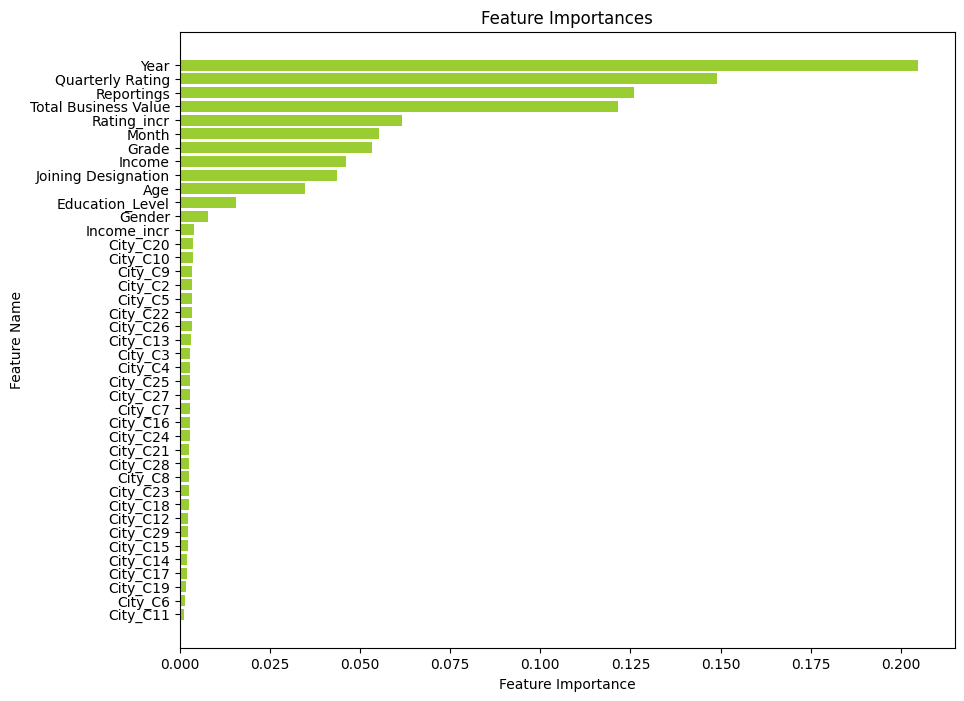

In [94]:
feature_importances = best_model.feature_importances_

# Assuming X_train_res is your training data
# Assuming column_names is a list containing the names of your features
# You may obtain column_names from your DataFrame if you used one initially

# Create a dictionary to store feature names and their importances
feature_importance_dict = dict(zip(X_train_res.columns, feature_importances))

# Sort the dictionary by importance values in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importances
sorted_feature_names = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='yellowgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Feature Importance in case of RandomForestClassifier:

* Year is the most important feature in determining Churn followed by Quarterly Ratings, Reportings and Business Values
* Least important is City, Income increment followed by Education Level and Age. Our initial EDA too inferred that Age and Education Level are not significant in determining Churn

**ROC Curve & AUC**

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model. It helps evaluate and compare different models by illustrating the trade-off between the true positive rate (TPR) and false positive rate (FPR) at various classification thresholds.


The area under the ROC curve (AUC) is a commonly used metric to quantify the overall performance of a classifier.


A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5. The higher the AUC value, the better the classifier's performance in distinguishing between positive and negative instances.

In [95]:
from sklearn.metrics import roc_curve, roc_auc_score

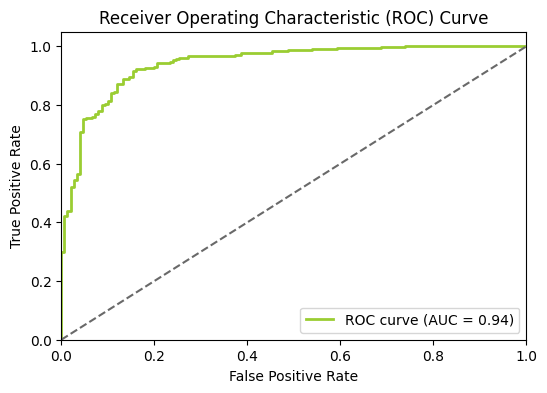

In [96]:
# Make predictions on the test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='yellowgreen', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='dimgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Performance Interpretation:

* An AUC of 0.94 means that there is a 94% chance that the model will correctly distinguish between a randomly chosen positive instance and a randomly chosen negative instance.

* High Discrimination Ability: The model has a strong ability to discriminate between the positive and negative classes.

Practical Implications:

* Model Reliability: An AUC of 0.94 suggests that the model is very reliable for making predictions and has a low likelihood of making incorrect classifications.
* Threshold Selection: The high AUC indicates that the model will perform well across a range of threshold settings, providing flexibility in choosing a threshold that balances sensitivity and specificity according to specific requirements.

**Precision Recall Curve**

The Precision-Recall (PR) curve is another graphical representation commonly used to evaluate the performance of a binary classification model. It provides insights into the trade-off between precision and recall at various classification thresholds.

In [97]:
from sklearn.metrics import precision_recall_curve,auc

In [98]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

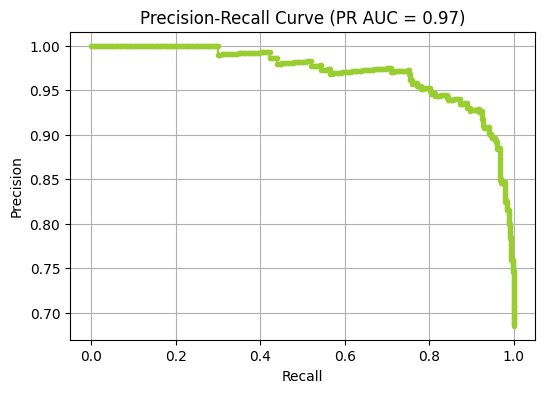

In [99]:
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.',color='yellowgreen')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = {:.2f})'.format(pr_auc))
plt.grid(True)
plt.show()

High PR AUC:

* A PR AUC of 0.97 is very high, indicating that the model has both high precision and high recall across different thresholds.
* This means the model is very good at identifying positive instances without producing many false positives.

Model Performance:

* High Precision: The model makes very few false positive errors, meaning that most of the positive predictions are correct.

* High Recall: The model successfully identifies a large proportion of actual positive instances, missing very few.

Context of Imbalanced Datasets:

* PR AUC is particularly informative when dealing with imbalanced datasets. In such scenarios, traditional metrics like accuracy can be misleading because they may be dominated by the majority class.

* The PR AUC provides a clearer picture of how well the model is performing with respect to the minority class (often the more important class in imbalanced datasets).

# Ensemble Learning: Boosting (LightGBM)

* Hyperparameter Tuning using GridsearchCV
* Model Score / Accuracy Measurement
* Confusion Matrix
* Feature Importance
* ROC Curve & AUC
* Precision Recall Curve

In [100]:
from lightgbm import LGBMClassifier

In [101]:
model = LGBMClassifier(silent=True, verbose=-1)

# Define the grid of parameters to search
gridParams = {
    'learning_rate': [0.1, 0.3, 0.5],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'max_depth': [5, 6, 7, 8],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7]
      }
# Setup GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=gridParams, cv=3, scoring='neg_log_loss',verbose=1)

start_time=time.time()
grid.fit(X_train_res, y_train_res)
end_time=time.time()

# Print the best parameters found
print("Best parameters found: ", grid.best_params_)
# Best score
print("Best log loss: ", -grid.best_score_)
print(f"Total training time: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'boosting_type': 'gbdt', 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'objective': 'binary', 'subsample': 0.5}
Best log loss:  0.23786119504245762
Total training time: 11.37 seconds


In [102]:
# Retrieve the best model (estimator)
best_model = grid.best_estimator_

# Make predictions on the test set
y_train_pred = best_model.predict(X_train_res)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the model
# Accuracy
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.96
Test Accuracy: 0.90


Observations:

* A log loss of 0.238 means that, on average, the model's predicted probabilities are close to the actual outcomes. It indicates that the model's probability predictions are relatively accurate.
* A training accuracy of 0.96 means that the model correctly predicts the class labels for 96% of the samples in the training dataset. It suggests that the model has learned the patterns present in the training data relatively well.
* A test accuracy of 0.90 means that the model correctly predicts the class labels for 90% of the samples in the test dataset. It suggests that the model performs well on unseen data, indicating good generalization ability.

**Confusion Matrix / Classification Report**

In [103]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[123  27]
 [ 23 304]]


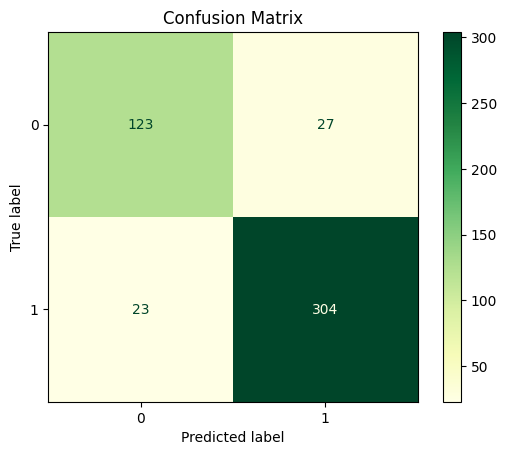

In [104]:
disp = ConfusionMatrixDisplay(conf_matrix)
cmap = plt.cm.YlGn
disp.plot(cmap=cmap)
plt.title('Confusion Matrix')
plt.show()

In [105]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       150
           1       0.92      0.93      0.92       327

    accuracy                           0.90       477
   macro avg       0.88      0.87      0.88       477
weighted avg       0.89      0.90      0.89       477



* Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. For class 0, the precision is 0.84, and for class 1, it is 0.92. This means that when the model predicts class 0, it is correct 84% of the time, and when it predicts class 1, it is correct 92% of the time.


* Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. For class 0, the recall is 0.82, and for class 1, it is 0.93. This implies that the model is able to capture 82% of the actual class 0 instances and 93% of the actual class 1 instances.


* F1-score: F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.83, and for class 1, it is 0.92. The weighted average of these scores is 0.90


* Support: Support is the number of actual occurrences of the class in the specified dataset. For class 0, the support is 150, and for class 1, it is 327.


* Accuracy: Accuracy is the ratio of correctly predicted observations to the total observations. In this case, the overall accuracy of the model on the test data is 0.90, meaning it correctly predicts the class for 90% of the samples.

**Feature Importance**

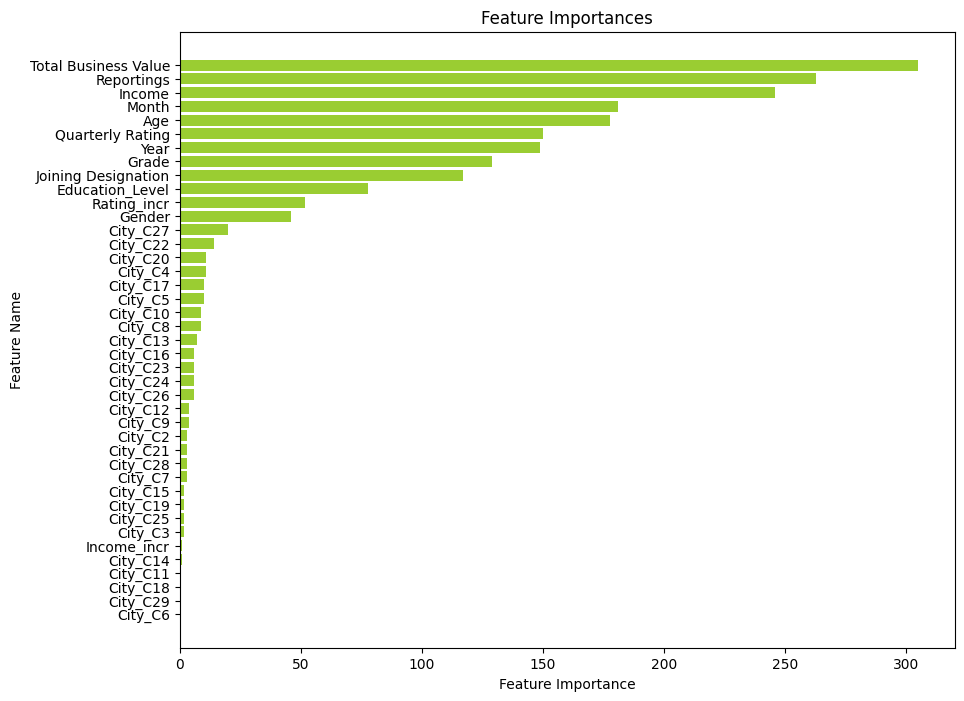

In [106]:
feature_importances = best_model.feature_importances_

# Assuming X_train_res is your training data
# Assuming column_names is a list containing the names of your features
# You may obtain column_names from your DataFrame if you used one initially

# Create a dictionary to store feature names and their importances
feature_importance_dict = dict(zip(X_train_res.columns, feature_importances))

# Sort the dictionary by importance values in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importances
sorted_feature_names = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances,color='yellowgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

Observations:

* Total Business Value is the most important feature followed by Reportings and Income
* City is least important followed by Income_increment and Gender

**ROC Curve & AUC**

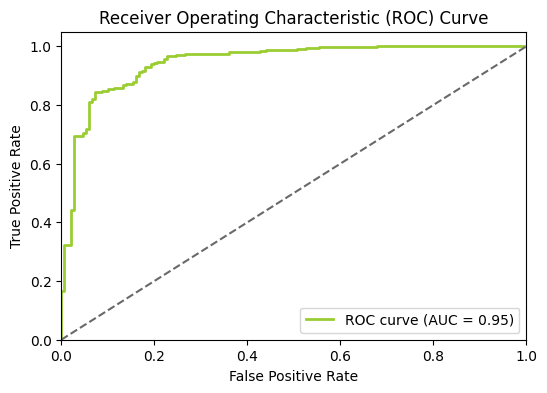

In [107]:
warnings.filterwarnings("ignore")
# Make predictions on the test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='yellowgreen', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='dimgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Observations:

An AUC of 0.95 means that the binary classification model has excellent discrimination ability, with high true positive rates and low false positive rates across different thresholds. It suggests that the model performs well in distinguishing between positive and negative samples, making it highly reliable for classification tasks.

**Precision Recall Curve**

In [108]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

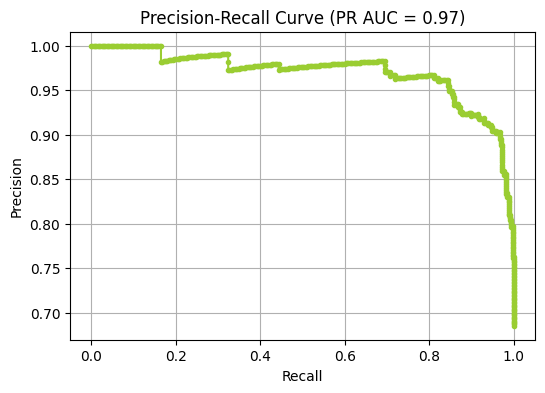

In [109]:
pr_auc = auc(recall, precision)
# Plot the precision-recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.',color='yellowgreen')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PR AUC = {:.2f})'.format(pr_auc))
plt.grid(True)

plt.show()

Observations:

* A PR AUC of 0.97 suggests that the binary classification model performs exceptionally well in terms of both precision and recall.


* It indicates that the model achieves very high precision (the proportion of true positive predictions among all positive predictions) and recall (the proportion of true positive predictions among all actual positive samples) across different thresholds.


* Such PR AUC value implies that the model makes very few false positive and false negative predictions, making it highly reliable for classification tasks, especially in scenarios where both precision and recall are crucial.

# Insights



* Five number of reportings are having highest frequency


* Males are higher in ratio than females among Drivers


* C20 is the city with maximum drivers


* Maximum Drivers have Grade 2


* Maximum number of Drivers have Quarterly Rating as 1


* 68% of the Drivers have been churned


* Hardly 2% of the Drivers got Increment in Income


* 15% of the Drivers got Increase in Rating


* 73% had their last Quarter Rating as 1 followed by 15% having 2


* Joining Designation is highest for 1 with 43% followed by 2 with 34%


* Grade at the time of Reporting is highest for Grade 2 with 36% followed by Grade 1 with 31%


* Distribution of Education Level for all 3 levels is almost same with 33%


* C20 is the city with highest number of drivers followed C15


* Males are higher in numbers with 59% and Females at 41%


* Most of the Drivers had their last working date in the month of July and year 2019


* Most of the Drivers joined in the month of July and year 2020


* Drivers with Grade 3 have highest business value followed by Grade 4 and 2


* The city with the most improvement in Quarterly Rating over the past year is C22


* Total Business Value of Drivers is highest in C29 followed by C26


* Average Quarterly Rating is found to be highest in 3rd Quarter and the same is found highest in the month of March


* There is no effect of Gender and Education Level on Churn


* 80% of the Drivers with Grade 1 got churned followed by Grade 2 with almost 70% churn


* Drivers with Joining Designation 1 and 5 got churned the most with almost 75%


* 80% of the Drivers with Quarterly Rating 1 left the company followed by 40% of QR2 and almost 18% of QR3


* Almost 77% of the Drivers who did not get any increase in Rating left the company


* 70% of the Drivers who did not get any increment in income left the company


* 80% of the Drivers from City C13 left the company closely followed by C17 and C23


* There is no significant observation on churn w.r.t joining month


* 90% of the Drivers who joined in the year 2018 left the company followed by 2019 and 2017


* Number of Reportings and Age are relatively lesser for Drivers who left


* Most of the Drivers getting churned belong to age between 25-35. Distribution is close to normal


* Income is less for the Drivers who left. Distribution is slightly right skewed


* Total Business Value is lesser for Drivers who left. Distribution is right skewed


* Reportings is highly positively correlated to Total Business Value


* Quarterly Rating and Rating_incr are highly correlated for obvious reasons


* Grade is highly positively correlated to Income and Joining Designations


* Above analysis helps determine that there is statistically significant impact of drop in Quarterly Rating on the subsequent period's Business Value


* Above OLS summary indicate impact of Age,Gender,Income,Joining Designation, Grade, Total Business Value on Quarterly Rating


* Driver's Total Business Value and Churn Rate both are affected by the City they operate in. It can be cleary inferred from the analysis done earlier


* Ensemble ML Bagging (RandomForestClassifier):

     F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.83, and for class 1, it is 0.92. The weighted average of these scores is 0.89.


* Ensemble ML Boosting (Light GBM):

    F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.83, and for class 1, it is 0.92. The weighted average of these scores is 0.90

# Recommendation


**1. Training and Development**

Driver Training Programs:

Target Audience: Drivers with Grade 2 and those in high-churn categories.

Content: Improve driving skills, customer service, and adherence to safety protocols.

Objective: Enhance performance and reduce churn rates.




**2. Incentive Schemes**

Performance-based Incentives:

Top Performers: Reward drivers with high business value and low churn rates.

Incentives: Financial bonuses, recognition programs, and career progression opportunities.

Churn Reduction: Special bonuses for drivers maintaining high quarterly ratings and consistent performance.

Focus: Encourage retention, especially for drivers in high-churn cities.


**3. Recruitment Strategies**

Targeted Recruitment: Cities with Growth Potential: Prioritize cities like C22 for recruitment drives.

Strategy: Highlight benefits and career growth opportunities in recruitment campaigns.

Demographics:

Age Group: Focus on drivers aged 25-35, who have shown high performance potential.

Gender Balance: Maintain a balanced recruitment strategy to address gender representation disparities.

**4. Operational Improvements**

City-Specific Strategies:

High Business Value Cities: Enhance support and resources in cities like C29 and C26.

Initiatives: Provide better infrastructure, more support staff, and improved working conditions.

Churn Management in High-Risk Cities: Implement special programs in cities with high churn rates (e.g., C13, C17, C23).

Approach: Conduct exit interviews to understand reasons for churn and address them proactively.


**5. Continuous Monitoring and Feedback**

Feedback Mechanisms:

Driver Surveys: Regularly collect feedback from drivers about their experiences, challenges, and suggestions.

Frequency: Quarterly surveys and feedback sessions.

Customer Feedback: Gather customer reviews and ratings to identify areas for improvement.

Integration: Use feedback to refine training programs and operational strategies.